In [1]:
from math import exp
import numpy as np
from xxhash import xxh32

from collections import Counter

import matplotlib.pyplot as plt

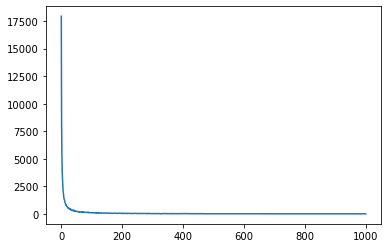

In [8]:
def zipf(a, d, n):
    data = np.zeros(n, dtype=int)
    p = np.arange(1, d+1)**(-a)
    p /= p.sum()
    for i in range(n):
        data[i] = np.random.choice(np.arange(d), p=p)
    return data

d = 1000
n = 100000

data = zipf(1.1, d, n)
freq = np.zeros(d)
for i in range(n):
    freq[data[i]] += 1
plt.plot(freq, linestyle='-')
plt.show()

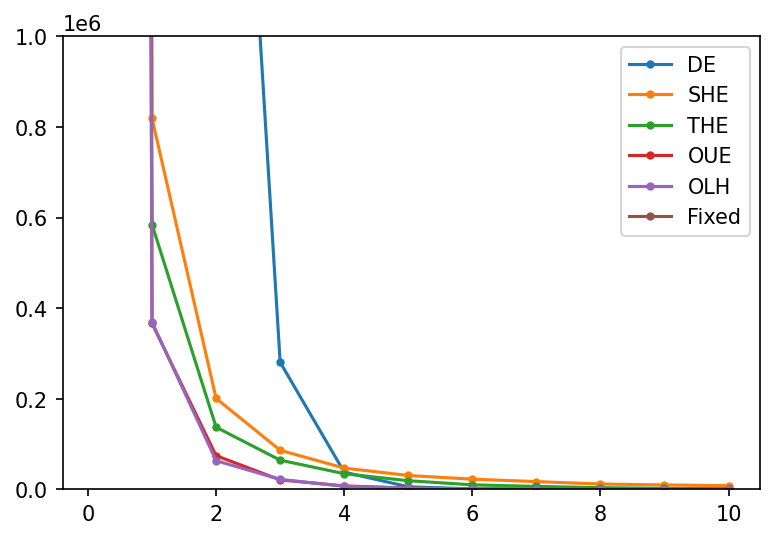

In [12]:
def MSE(freq, true_freq):
    return ((freq - true_freq)**2).mean()

def DE(data, d, epsilon):
    p = exp(epsilon)/(exp(epsilon) + d - 1)
    q = 1/(exp(epsilon) + d - 1)
    aggregated_data = np.zeros(d, dtype=int)
    for item in data:
        private_data = item
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, d)
        aggregated_data[private_data] += 1
    return (aggregated_data - len(data)*q)/(p - q)

def SHE(data, d, epsilon):
    aggregated_data = np.zeros(d)
    for i in range(len(data)):
        private_data = np.zeros(d)
        private_data[data[i]] = 1
        private_data += np.random.laplace(0, 2/epsilon, d)
        aggregated_data += private_data
    return aggregated_data

def THE(data, d, epsilon, threshold):
    p = 1 - exp(epsilon*(threshold - 1)/2)/2
    q = exp(-epsilon*threshold/2)/2
    aggregated_data = np.zeros(d)
    for i in range(len(data)):
        private_data = np.zeros(d)
        private_data[data[i]] = 1
        aggregated_data += np.where(private_data == 1, 
            np.random.binomial(1, p, d), 
            np.random.binomial(1, q, d))
    return (aggregated_data - len(data)*q)/(p - q)

def OUE(data, d, epsilon):
    p = 1 - 1/2
    q = 1/(exp(epsilon)+1)
    aggregated_data = np.zeros(d)
    for item in data:
        private_data = np.zeros(d)
        private_data[item] = 1
        aggregated_data += np.where(private_data == 1, 
            np.random.binomial(1, p, d), 
            np.random.binomial(1, q, d))
    return (aggregated_data - len(data)*q)/(p - q)

def OLH(data, d, epsilon):
    g = int(round(exp(epsilon))) + 1
    p = exp(epsilon)/(exp(epsilon) + g - 1)
    q = 1/(exp(epsilon) + g - 1)
    aggregated_data = np.zeros(d)
    for i, item in enumerate(data):
        private_data = (xxh32(str(item), seed=i).intdigest() % g)
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, g)
        for j in range(d):
            if private_data == (xxh32(str(j), seed=i).intdigest() % g):
                aggregated_data[j] +=  1
    return (g*aggregated_data - len(data))/(p*g - 1)
    
t = 1

var_de = []
var_she = []
var_the = []
var_oue = []
var_olh = []
eps_range = np.concatenate(([0.1], np.arange(1, 11, 1)))
for epsilon in eps_range:
    freq_de = DE(data, d, epsilon)
    freq_she = SHE(data, d, epsilon)
    freq_the = THE(data, d, epsilon, t)
    freq_oue = OUE(data, d, epsilon)
    freq_olh = OLH(data, d, epsilon)
    var_de.append(MSE(freq_de, freq))
    var_she.append(MSE(freq_she, freq))
    var_the.append(MSE(freq_the, freq))
    var_oue.append(MSE(freq_oue, freq))
    var_olh.append(MSE(freq_olh, freq))
plt.figure(dpi=150)
plt.plot(eps_range, var_de, linestyle='-', marker='.', label='DE')
plt.plot(eps_range, var_she, linestyle='-', marker='.', label='SHE')
plt.plot(eps_range, var_the, linestyle='-', marker='.', label='THE')
plt.plot(eps_range, var_oue, linestyle='-', marker='.', label='OUE')
plt.plot(eps_range, var_olh, linestyle='-', marker='.', label='OLH')
plt.plot(eps_range, [MSE(n/2, freq)]*11, linestyle='-', marker='.', label='Fixed')
plt.legend()
plt.ylim(0, 1e6)
plt.show()

486434.210312753 486434.3652834699
486434.84515657276 486434.72031718167
486434.47338422656 486434.76859574753
486434.61073754117 486434.5601715863
486434.57285031496 486434.6405545972
486434.67892547447 486434.63380423153
486434.60233213176 486434.69433679985
486434.69596731535 486434.75404416636
486434.6979536231 486434.6388443344
486434.776552071 486434.69348792976


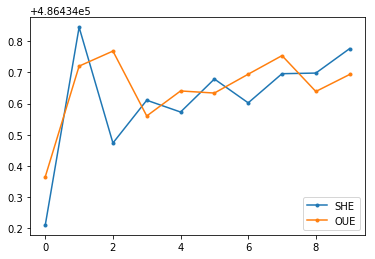

In [14]:
def MAPE(freq, true_freq):
    freq /= freq.sum()
    true_freq /= true_freq.sum()
    return (abs(freq - true_freq)/(true_freq + np.finfo(np.float32).eps)).mean()
    
def MLE_SHE(data, d, epsilon):
    data = data[np.argsort(epsilon)]
    regime = Counter(epsilon)

    weight = np.zeros(len(regime))
    for i, eps in enumerate(regime.keys()):
        var = regime[eps] * 8/eps**2
        weight[i] = 1/var
    weight /= weight.sum()

    freq = np.zeros(d)
    for i, eps in enumerate(regime.keys()):
        freq += weight[i] * SHE(data[epsilon==eps], d, eps)
    return freq

def MLE_OUE(data, d, epsilon):
    data = data[np.argsort(epsilon)]
    regime = Counter(epsilon)

    weight = np.zeros(len(regime))
    for i, eps in enumerate(regime.keys()):
        var = regime[eps] * 4*exp(eps)/(exp(eps) - 1)**2
        weight[i] = 1/var
    weight /= weight.sum()

    freq = np.zeros(d)
    for i, eps in enumerate(regime.keys()):
        freq += weight[i] * OUE(data[epsilon==eps], d, eps)
    return freq

# epsilon = np.random.normal(3, 1, n)
# epsilon = np.clip(epsilon, 0.1, None)
# plt.hist(epsilon, 100)
# plt.show()

var_she = []
var_oue = []
for i in range(1, 11):
    epsilon = np.random.normal(i, 1, n)
    epsilon = np.clip(epsilon, 0.1, None)
    freq_she = MLE_SHE(data, d, epsilon)
    freq_oue = MLE_OUE(data, d, epsilon)
    print(MSE(freq_she, freq), MSE(freq_oue, freq))
    var_she.append(MSE(freq_she, freq))
    var_oue.append(MSE(freq_oue, freq))
plt.plot(var_she, linestyle='-', marker='.', label='SHE')
plt.plot(var_oue, linestyle='-', marker='.', label='OUE')
plt.legend()
plt.show()

In [10]:
a = np.array([1.1, 0.2])
print(a > 1)

[ True False]
